In [1]:
import pandas as pd
import numpy as np
import requests
import shutil
import os
import gzip
import matplotlib
from pathlib import Path
import re
from tqdm import tqdm
from urllib.request import urlretrieve
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from glob import glob
from datetime import datetime
from scipy import interpolate
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
#Assign the local float directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:
url_links = {
    'Cabot' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Cabot_20240528/Cabot_645_R.nc',
    'Nelson' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Nelson_20240528/Nelson_646_R.nc',
    'Doombar' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Doombar_20240528/Doombar_648_R.nc',
    'Churchill' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Churchill_20240528/Churchill_647_R.nc'}

In [4]:
def download_glider_nc(url):
    glider_url = url
    gliders_dir =  os.path.join(parent_dir, 'Data/Gliders')
    glider_filename = gliders_dir + '/' + glider_url.rsplit('/', 1)[1]
    urlretrieve(glider_url, glider_filename)
    return(glider_filename)

In [21]:
def glider_to_pd(nc_path, glider_name, cols):
    dat = xr.open_dataset(nc_path)
    mission_date = pd.to_datetime("2024-05-28 18:57:00")
    dates_nc = dat['TIME']
    filtered_dat = dat.where(dates_nc > mission_date, drop=True)
    df_glid = filtered_dat[cols].to_dataframe()
    dat.close()
    #df_glid['PRES'] = df_glid['PRES'].interpolate()
    df_glid['CHLA'] = df_glid['CHLA'].interpolate()
    df_glid['BBP700'] = df_glid['BBP700'].interpolate()
    df_glid['glider'] = glider_name
    return(df_glid)

In [6]:
def get_gliders_df(cols):
    gliders_df = pd.DataFrame(columns=cols)
    for glider, url in url_links.items():
        data = download_glider_nc(url)
        print(f'{glider} data downloaded')
        df = glider_to_pd(data, glider, cols)
        gliders_df = pd.concat([gliders_df if not gliders_df.empty else None, df])
    return(gliders_df)

In [22]:
cols = ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'CHLA', 'BBP700', 'TEMP']
gliders_df = get_gliders_df(cols)

Cabot data downloaded
Nelson data downloaded
Doombar data downloaded
Churchill data downloaded


In [23]:
today = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
today_file = datetime.now().strftime("%Y%m%d_%H%M%S")

In [9]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1,  projection=ccrs.Mercator())
figname = os.path.join(parent_dir, 'Output/Plots/gliders/gliders_transect_' + today_file + '.png')
for glider_name in url_links.keys():
    temp = gliders_df[gliders_df['glider'] == glider_name]
    sc = ax.scatter(temp['LONGITUDE'], temp['LATITUDE'], label = glider_name, transform=ccrs.PlateCarree())

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

# Add a scale bar
ax.add_artist(ScaleBar(1, location = "lower left"))

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.legend()
plt.title(f'Gliders transects \n Updated : {today}')
plt.savefig(figname)
plt.close()
plt.clf()

<Figure size 640x480 with 0 Axes>

In [18]:
def plot_bgc_var(ax, glider_name, var='CHLA', surface=False):
    
    if surface == True:
        plotting_df = gliders_df[gliders_df['PRES'] < 100]
    else:
        plotting_df = gliders_df[gliders_df['PRES'] < 1000]
    if var == 'TEMP':
        plotting_df = plotting_df[plotting_df['TEMP'] > -0.5]

    spec_df = plotting_df[plotting_df['glider'] == glider_name]
    sc = ax.scatter(spec_df['TIME'], -spec_df['PRES'], c=spec_df[var], cmap='viridis')
    cbar = plt.colorbar(sc, ax=ax, label=var)

    ax.set_xlabel('Time')
    ax.set_ylabel('Depth (m)')
    ax.set_title(f'Glider: {glider_name}')

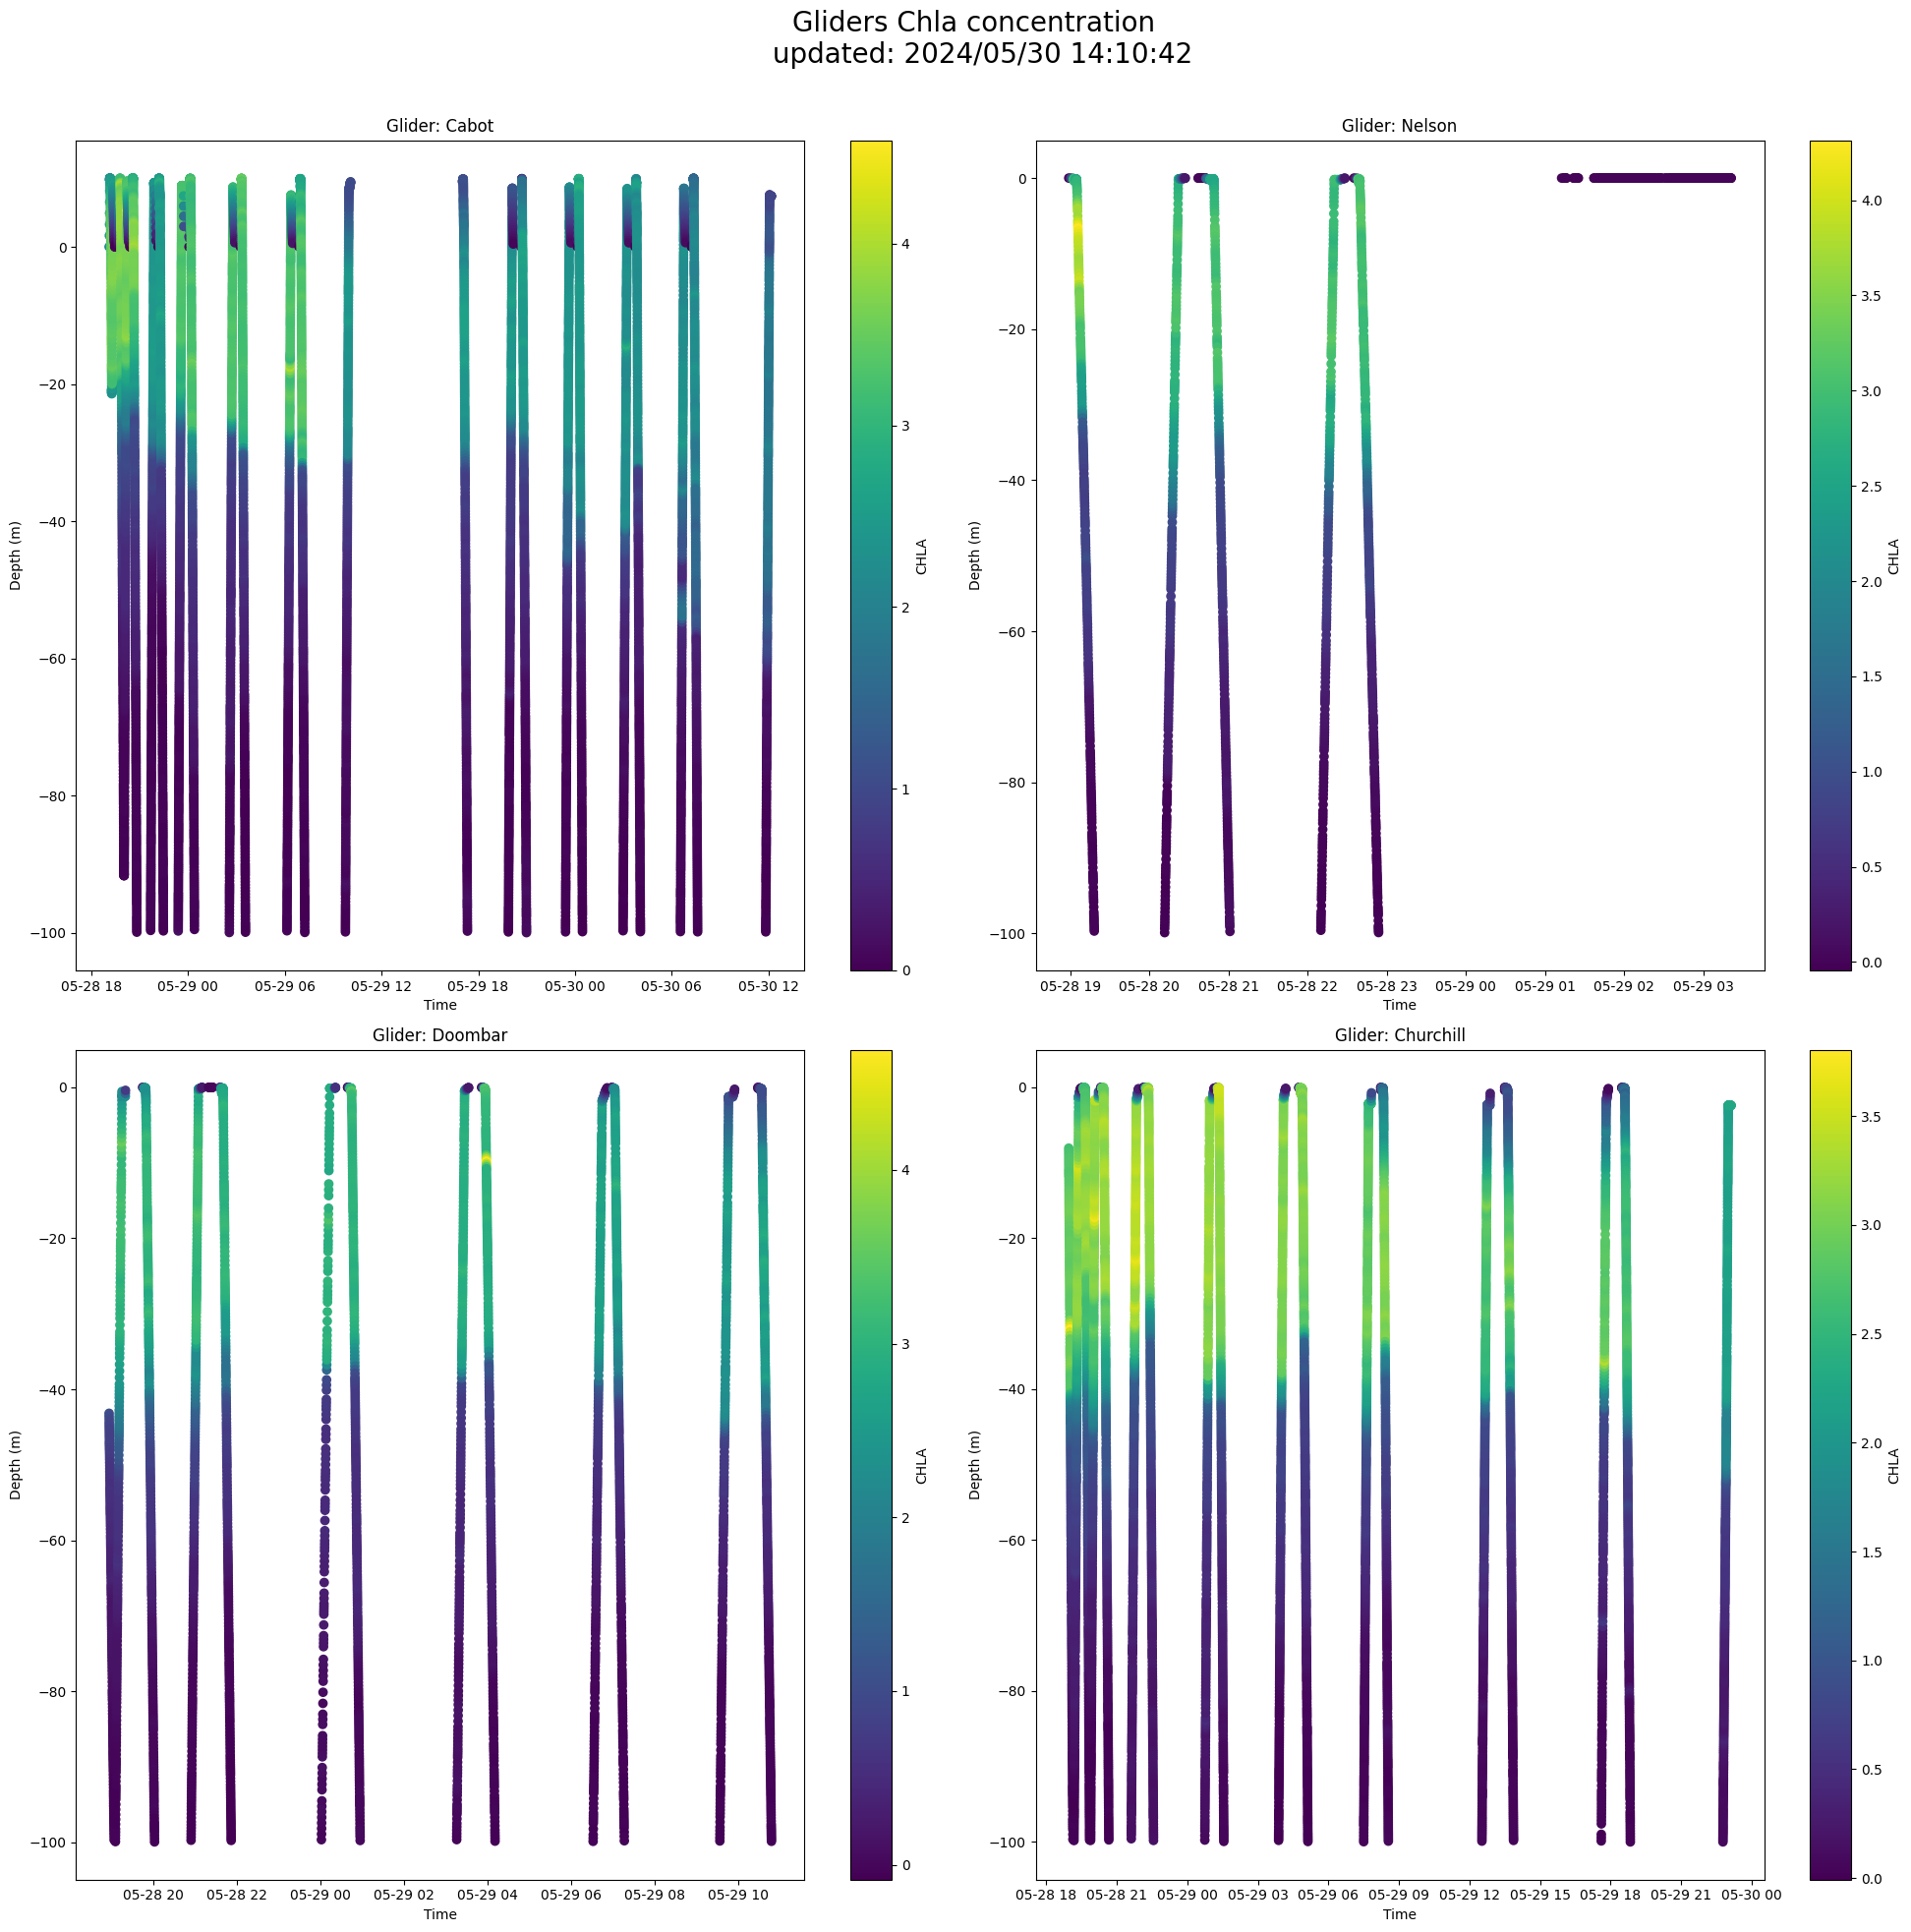

In [11]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Loop through glider names and axes
for ax, glider_name in zip(axs, url_links.keys()):
    plot_bgc_var(ax, glider_name, var='CHLA', surface=True)


fig.suptitle(f'Gliders Chla concentration \n updated: {today}', size = 20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

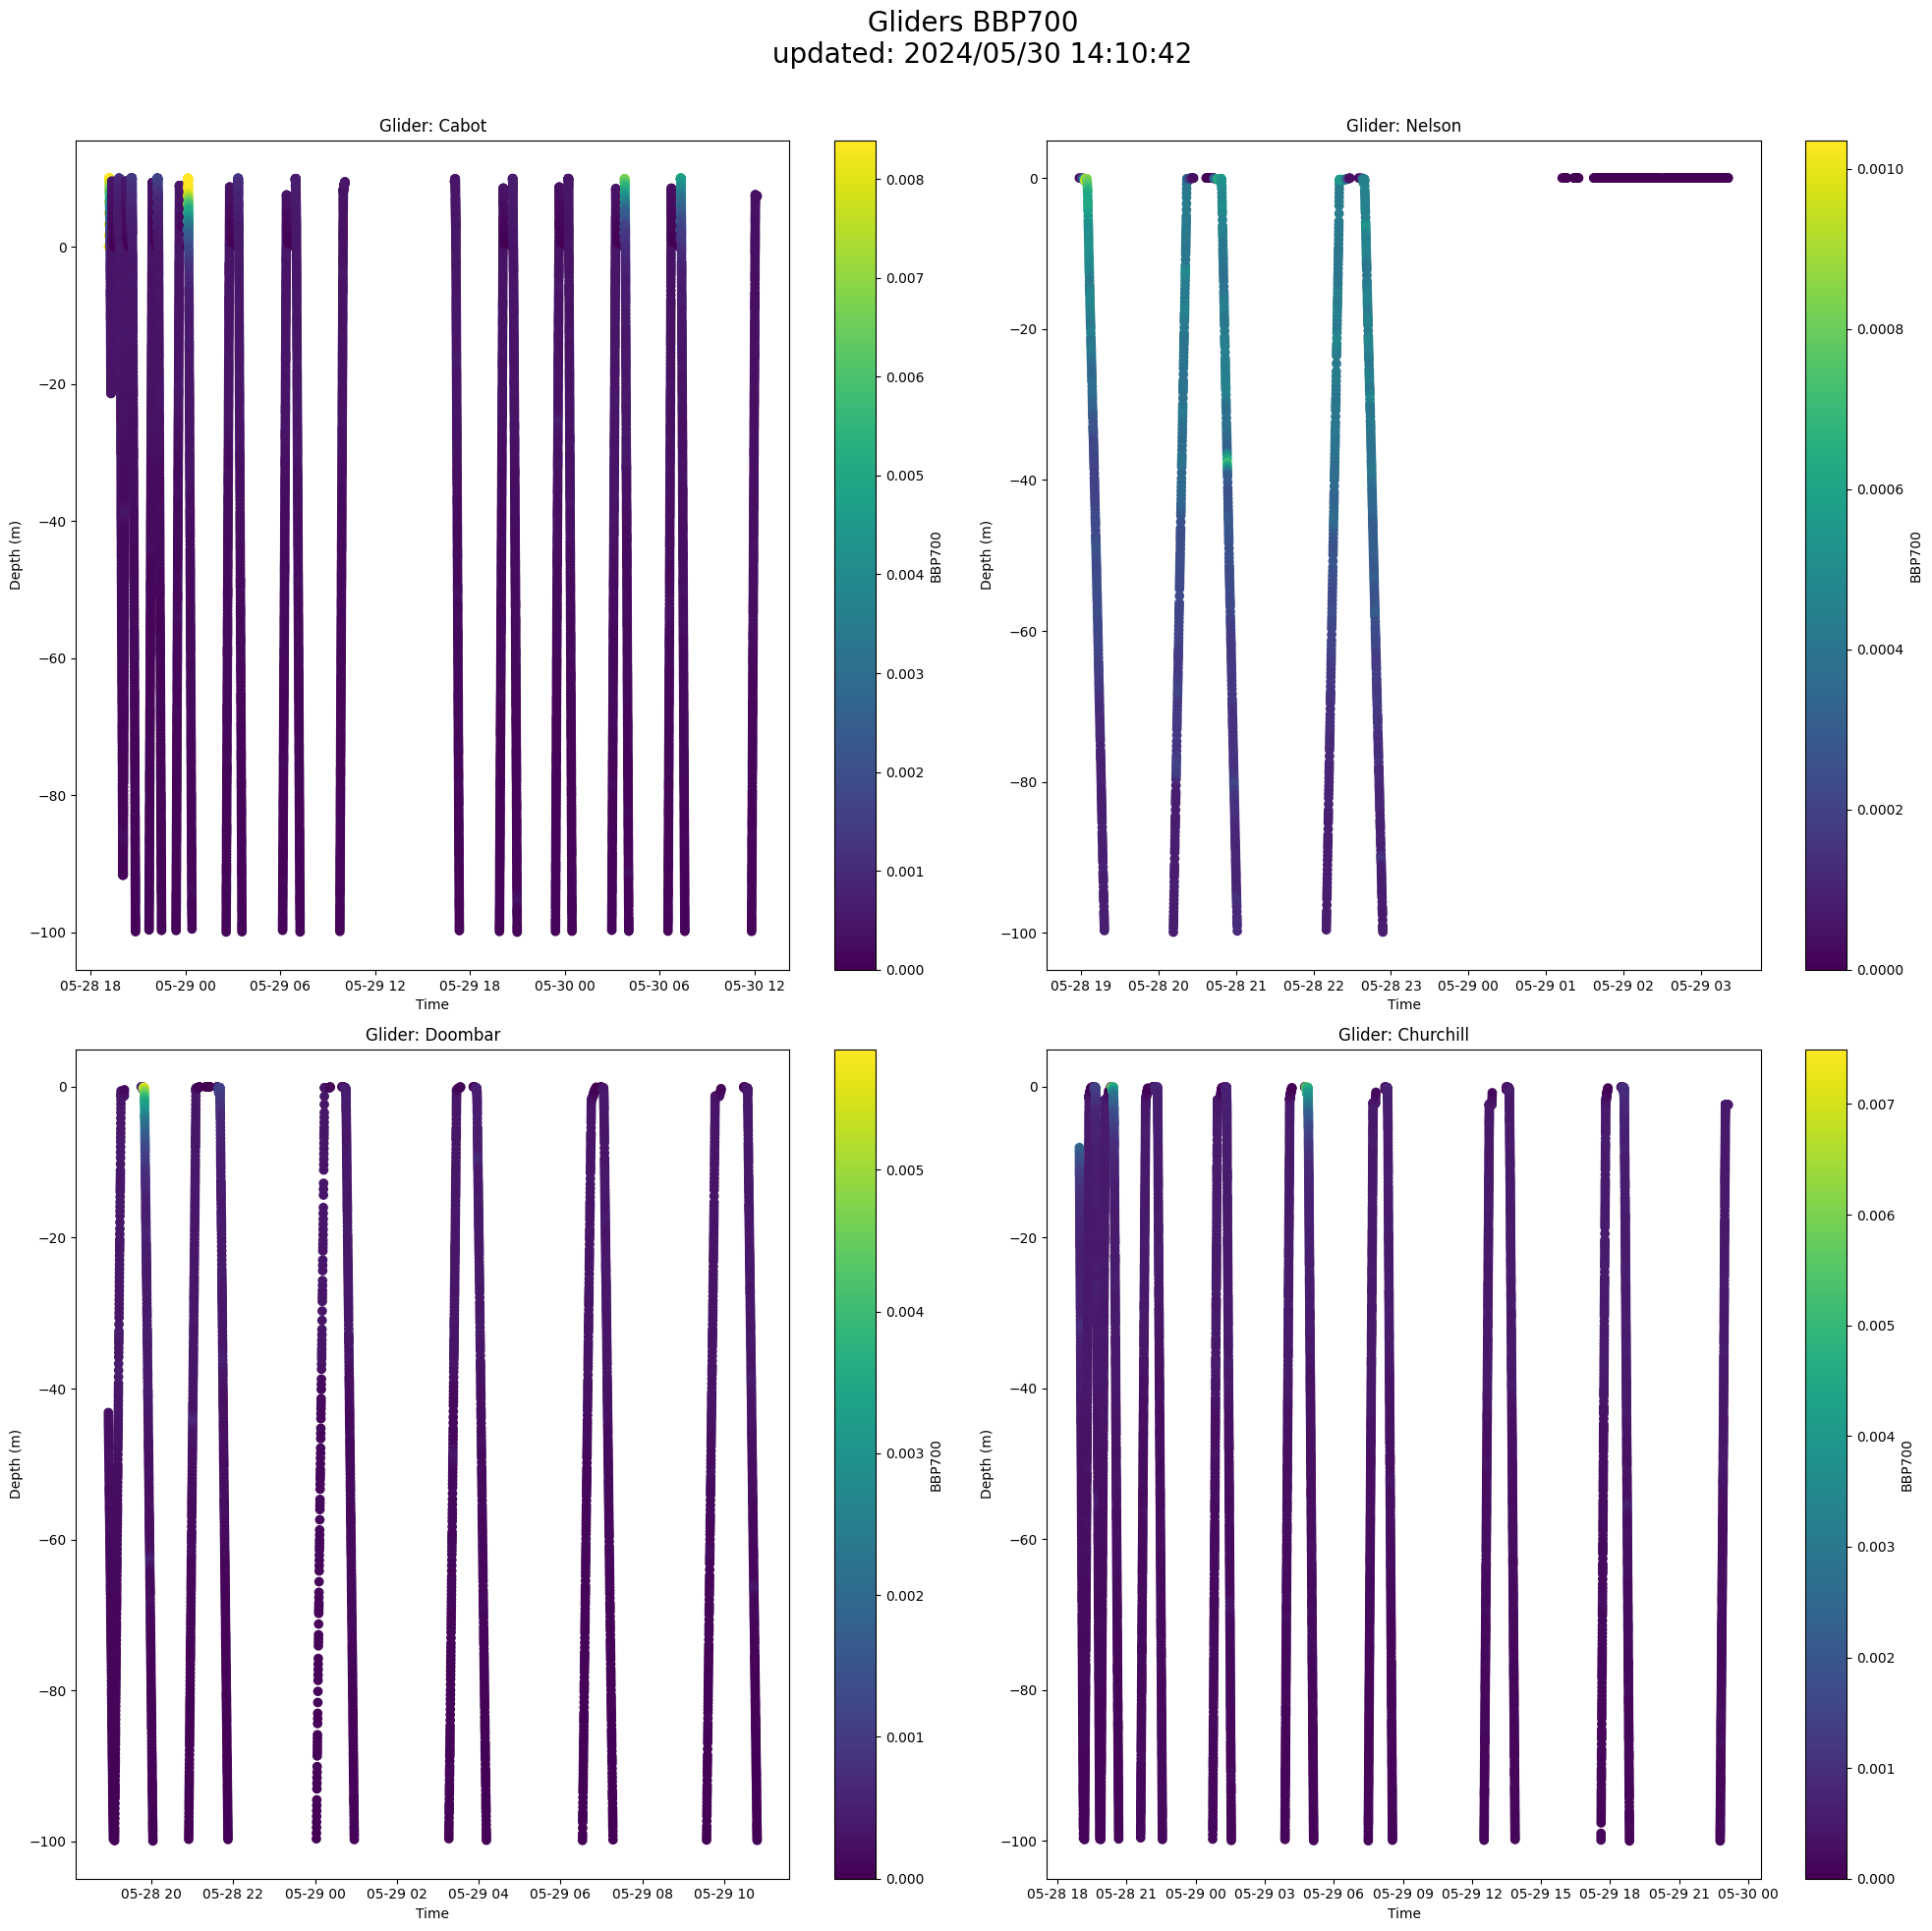

In [12]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Loop through glider names and axes
for ax, glider_name in zip(axs, url_links.keys()):
    plot_bgc_var(ax, glider_name, var='BBP700', surface=True)


fig.suptitle(f'Gliders BBP700 \n updated: {today}', size = 20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

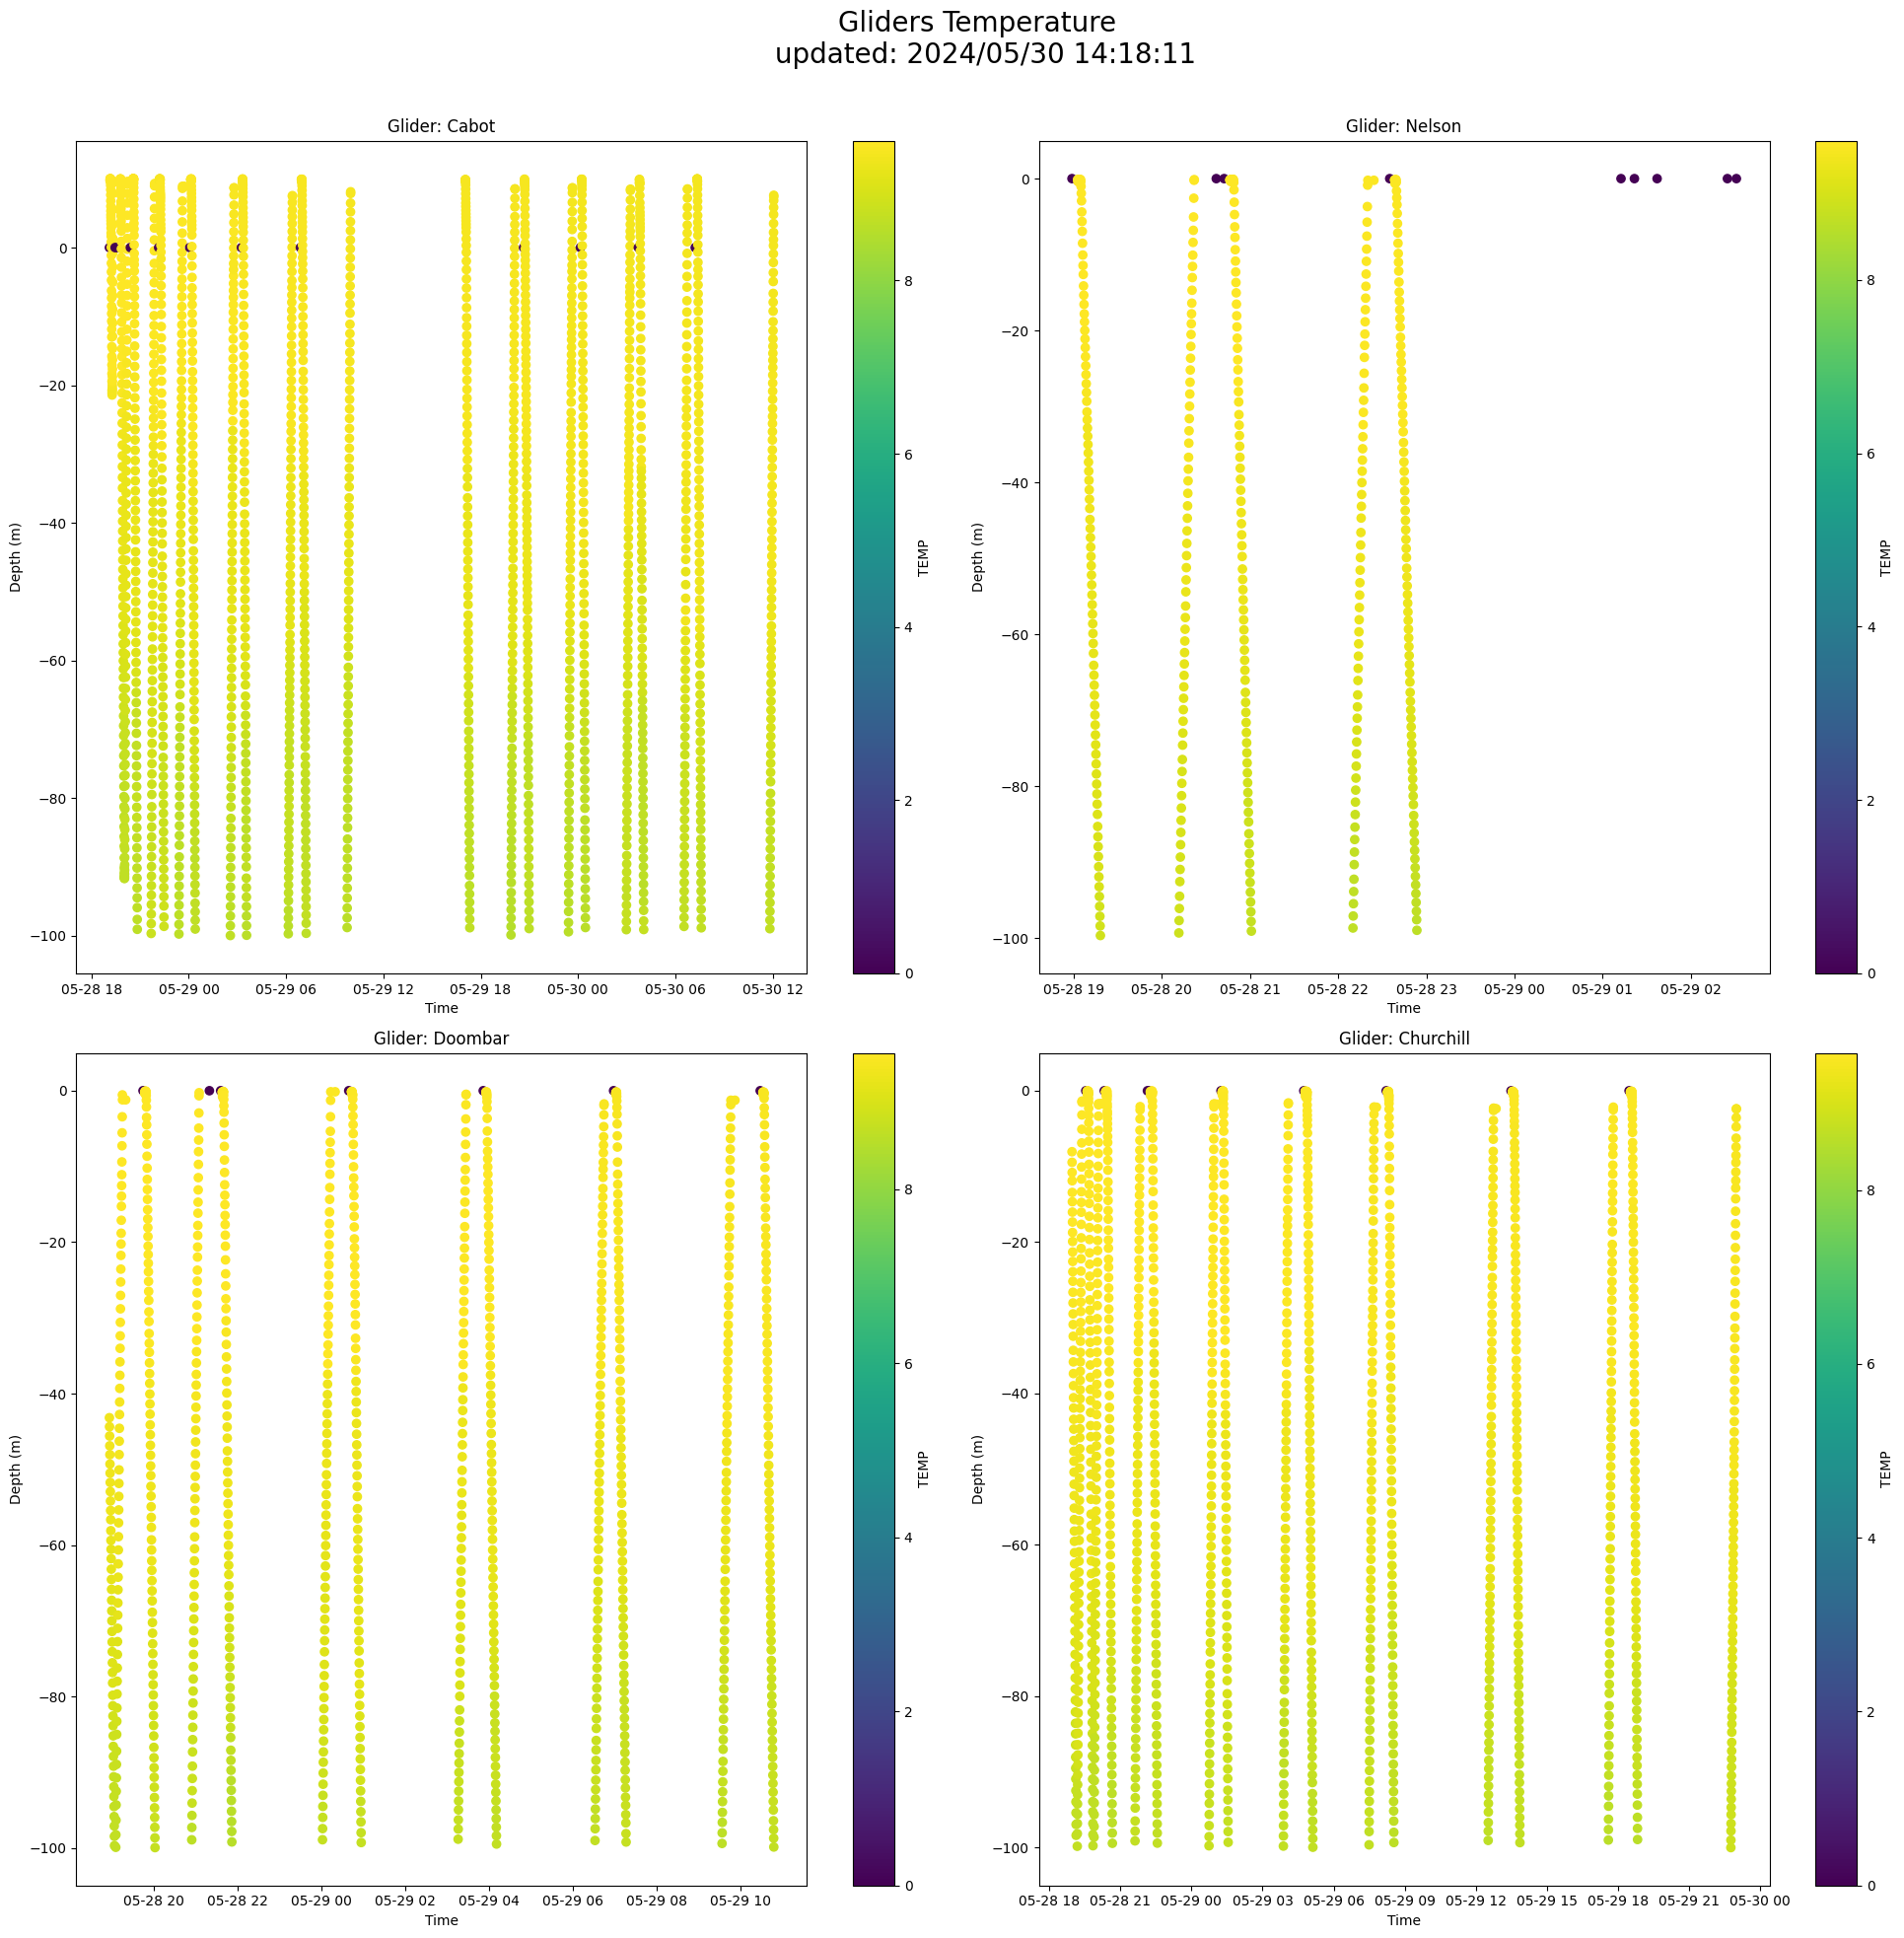

In [24]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Loop through glider names and axes
for ax, glider_name in zip(axs, url_links.keys()):
    plot_bgc_var(ax, glider_name, var='TEMP', surface=True)


fig.suptitle(f'Gliders Temperature \n updated: {today}', size = 20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [25]:
dat = xr.open_dataset(download_glider_nc('https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Cabot_20240528/Cabot_645_R.nc'))

In [34]:
pres = dat['PRES'].values
pres = pres[~np.isnan(pres)]
pres.min()

-10.290001

In [26]:
display(dat)

<xarray.Dataset> Size: 7MB
Dimensions:                                   (N_MEASUREMENTS: 40938,
                                               N_PARAM: 18)
Dimensions without coordinates: N_MEASUREMENTS, N_PARAM
Data variables: (12/55)
    TIME                                      (N_MEASUREMENTS) datetime64[ns] 328kB ...
    TIME_GPS                                  (N_MEASUREMENTS) datetime64[ns] 328kB ...
    PHASE                                     (N_MEASUREMENTS) float32 164kB ...
    PHASE_QC                                  (N_MEASUREMENTS) float32 164kB ...
    PRES                                      (N_MEASUREMENTS) float32 164kB ...
    CNDC                                      (N_MEASUREMENTS) float32 164kB ...
    ...                                        ...
    PLATFORM_TYPE                             <U6 24B ...
    PLATFORM_MODEL                            <U2 8B ...
    WMO_IDENTIFIER                            <U3 12B ...
    DEPLOYMENT_TIME                           datetime64[ns] 8B ...
    DEPLOYMENT_LATITUDE                       <U18 72B ...
    DEPLOYMENT_LONGITUDE                      <U19 76B ...
Attributes: (12/68)
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:5831
    geospatial_lat_min:              50.891804
    geospatial_lat_max:              60.00001
    geospatial_lon_min:              -24.0015
    geospatial_lon_max:              -1.3949883
    ...                              ...
    instrument:                      ['SBE Slocum Glider Payload (GPCTD) CTD'...
    metadata_link:                   https://api.linked-systems.uk/api/meta/v...
    trajectory:                      Cabot_20240528
    date_created:                    2024-05-30T14:11:00.183079
    date_modified:                   2024-05-30T14:11:00.183092
    id:                              Cabot_20240528T000000_R